In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
data_train = os.path.join('../data/Garbage classification')
labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [3]:
for label in labels:
    directory = os.path.join(data_train, label)
    print(f"Found {len(os.listdir(directory))} images of {label}")

Found 403 images of cardboard
Found 501 images of glass
Found 410 images of metal
Found 594 images of paper
Found 482 images of plastic
Found 137 images of trash


In [29]:
def plot_loss(history, epochs):
    plt.figure()
    plt.title(f'CNN Loss - batch size {batch_size}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(range(1, epochs+1), history.history['val_loss'])
    plt.plot(range(1, epochs+1), history.history['loss'])
    plt.legend(['Validation Loss', 'Training Loss'])
    plt.savefig('./model/cnn_plots/CNN_Loss_Epoch_100.png')

def plot_accuracy(history, epochs):
    plt.figure()
    plt.title(f'CNN Accuracy - batch size {batch_size}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(range(1, epochs+1), history.history['val_accuracy'])
    plt.plot(range(1, epochs+1), history.history['accuracy'])
    plt.legend(['Validation Accuracy', 'Training Accuracy'])
    plt.savefig('./model/cnn_plots/CNN_Accuracy_Epoch_100.png')

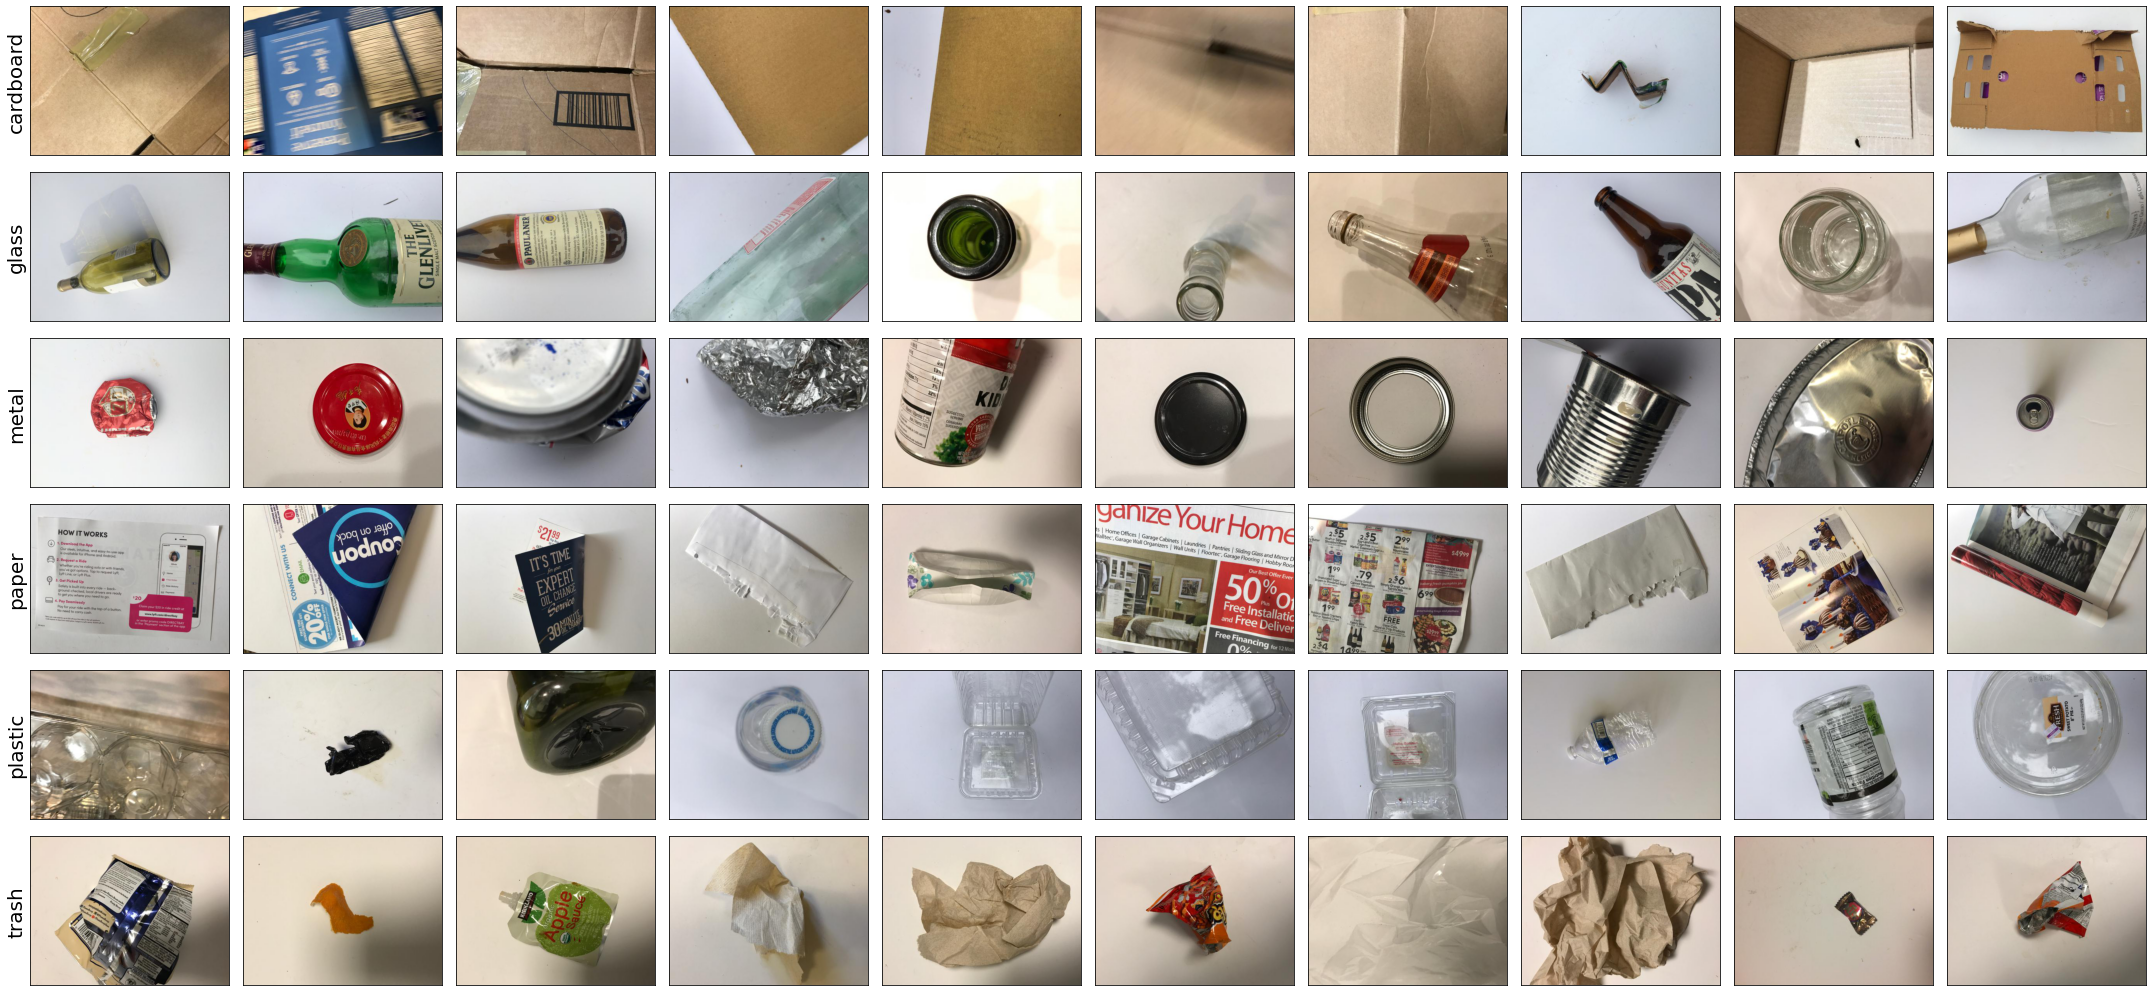

In [6]:
# Visualizing the data
def plot_images():
    plt.figure(figsize=(30,14))

    for i, label in enumerate(labels):
        directory = os.path.join(data_train, label)
        for j in range(10):
            path = os.path.join(directory, os.listdir(directory)[j])
            img = mpimg.imread(path)

            plt.subplot(6, 10, i*10 + j + 1)
            plt.imshow(img)

            if j == 0:
                plt.ylabel(labels[i], fontsize=20)

    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
    plt.tight_layout()
    plt.show()

plot_images()

In [5]:
# Size of the image
directory = os.path.join(data_train, 'trash')
path = os.path.join(directory, os.listdir(directory)[0])
image = mpimg.imread(path)
image.shape

(384, 512, 3)

In [23]:
#hyperparaters
validation_split = 0.1
batch_size = 10
image_size = (224, 224)
epochs = 100
learning_rate = 1e-3

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='../data/train',
    validation_split=validation_split,
    subset="training",
    label_mode="categorical",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='../data/train',
    validation_split=validation_split,
    subset="validation",
    label_mode="categorical",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)

Found 1766 files belonging to 6 classes.
Using 1590 files for training.
Found 1766 files belonging to 6 classes.
Using 176 files for validation.


In [9]:
train_ds, val_ds

(<BatchDataset shapes: ((None, 224, 224, 3), (None, 6)), types: (tf.float32, tf.float32)>,
 <BatchDataset shapes: ((None, 224, 224, 3), (None, 6)), types: (tf.float32, tf.float32)>)

In [24]:
def make_cnn_model(input_shape, labels, num_dense_layers):
    inputs = keras.Input(shape=input_shape)
    
    model = keras.Sequential()
    model.add(inputs)
    model.add(layers.Rescaling(1./255))
    
    model.add(layers.Conv2D(32, 3, padding="same", activation="relu", input_shape=input_shape))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, 3, padding="same", activation="relu"))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, 3, padding="same", activation="relu"))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    
    for _ in range(num_dense_layers):
        model.add(layers.Dense(units=64, activation="relu"))
        model.add(layers.Dropout(0.5))
        
    model.add(layers.Dense(units=labels, activation="softmax"))
    
    return model 

In [25]:
model = make_cnn_model(input_shape=image_size + (3,), labels=len(labels), num_dense_layers=2)
model.build()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 128)      

In [26]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./model/cnn/save_at_{epoch}.h5",
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )
]
model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

Epoch 1/100
159/159 [==============================] - 5s 25ms/step - loss: 1.8056 - accuracy: 0.2113 - val_loss: 1.7442 - val_accuracy: 0.1932
Epoch 2/100
159/159 [==============================] - 4s 22ms/step - loss: 1.7468 - accuracy: 0.2119 - val_loss: 1.7418 - val_accuracy: 0.1932
Epoch 3/100
159/159 [==============================] - 4s 21ms/step - loss: 1.7349 - accuracy: 0.2358 - val_loss: 1.7360 - val_accuracy: 0.1932
Epoch 4/100
159/159 [==============================] - 4s 23ms/step - loss: 1.6932 - accuracy: 0.2572 - val_loss: 1.6625 - val_accuracy: 0.2955
Epoch 5/100
159/159 [==============================] - 4s 24ms/step - loss: 1.5856 - accuracy: 0.3126 - val_loss: 1.5725 - val_accuracy: 0.3295
Epoch 6/100
159/159 [==============================] - 4s 22ms/step - loss: 1.5264 - accuracy: 0.3465 - val_loss: 1.5236 - val_accuracy: 0.4091
Epoch 7/100
159/159 [==============================] - 4s 21ms/step - loss: 1.4427 - accuracy: 0.4101 - val_loss: 1.4693 - val_accuracy:

159/159 [==============================] - 3s 21ms/step - loss: 0.4085 - accuracy: 0.8453 - val_loss: 2.4706 - val_accuracy: 0.5284
Epoch 58/100
159/159 [==============================] - 3s 21ms/step - loss: 0.4008 - accuracy: 0.8428 - val_loss: 2.2543 - val_accuracy: 0.5000
Epoch 59/100
159/159 [==============================] - 4s 22ms/step - loss: 0.3492 - accuracy: 0.8528 - val_loss: 2.3163 - val_accuracy: 0.5227
Epoch 60/100
159/159 [==============================] - 3s 21ms/step - loss: 0.4067 - accuracy: 0.8415 - val_loss: 2.4797 - val_accuracy: 0.4773
Epoch 61/100
159/159 [==============================] - 3s 21ms/step - loss: 0.4325 - accuracy: 0.8214 - val_loss: 2.6353 - val_accuracy: 0.5170
Epoch 62/100
159/159 [==============================] - 3s 21ms/step - loss: 0.3935 - accuracy: 0.8503 - val_loss: 2.6264 - val_accuracy: 0.4886
Epoch 63/100
159/159 [==============================] - 4s 22ms/step - loss: 0.3600 - accuracy: 0.8660 - val_loss: 2.4956 - val_accuracy: 0.500

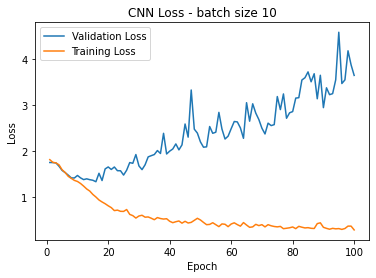

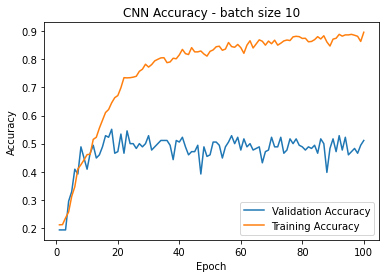

In [30]:
plot_loss(history, epochs=epochs)
plot_accuracy(history, epochs=epochs)

In [28]:
import joblib

path = './model/cnn_history'
if not os.path.exists(path):
    os.makedirs(path)
    
joblib.dump(history.history, os.path.join(path, 'epoch_100.joblib'))


['./model/cnn_history/epoch_100.joblib']

In [33]:
def predict(category):
    directory = os.path.join('../data/train', category)

    path = os.path.join(directory, os.listdir(directory)[10])
    img = mpimg.imread(path)
    x = tf.keras.preprocessing.image.smart_resize(
        img, (224,224), interpolation='bilinear'
    )

    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images)
    pred = labels[np.argmax(classes)]

    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title('Actual: {}      Pred: {}'.format(category, pred))

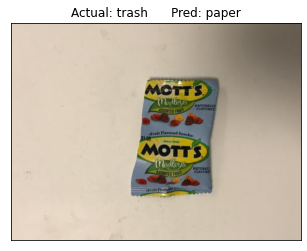

In [34]:
predict('trash')

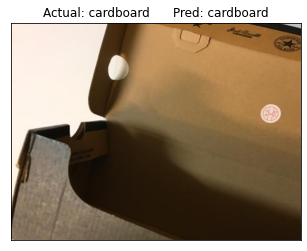

In [36]:
predict('cardboard')

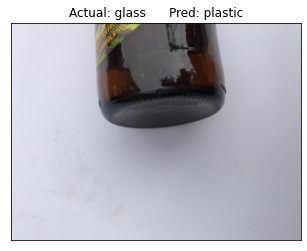

In [38]:
predict('glass')

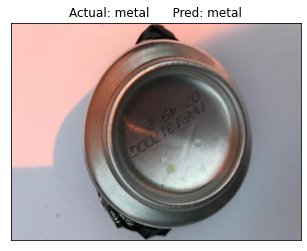

In [39]:
predict('metal')

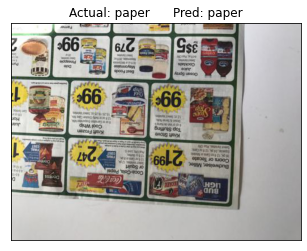

In [40]:
predict('paper')

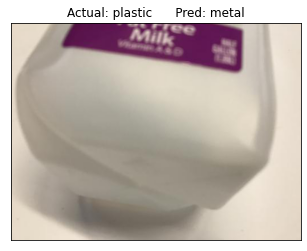

In [41]:
predict('plastic')